In [17]:
import os
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import regions
import radio_beam
from astropy.coordinates import SkyCoord
from astropy import units as u
import pylab as pl

In [18]:
coord = SkyCoord("17:45:57.7530532310 -28:57:10.7694483833", unit=(u.h, u.deg), frame='icrs')
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [39]:
region = regions.RectangleSkyRegion(center=coord, width=15*u.arcsec, height=15*u.arcsec)
smallregion = regions.RectangleSkyRegion(center=coord, width=4*u.arcsec, height=4*u.arcsec)
cutregion = regions.CircleSkyRegion(center=coord, radius=15*u.arcsec) # circumscribe the above region so we can match RA/Dec to Galactic

In [20]:
bigregion = regions.RectangleSkyRegion(center=coord, width=35*u.arcsec, height=35*u.arcsec)
bigcircregion = regions.CircleSkyRegion(center=coord, radius=35*u.arcsec)

In [21]:
biggerregion = regions.RectangleSkyRegion(center=coord, width=65*u.arcsec, height=65*u.arcsec)

In [30]:
def galactic_cutout(hdu, reg):
    import reproject.mosaicking, reproject
    csys, sz = reproject.mosaicking.find_optimal_celestial_wcs(hdu, frame='galactic')
    newdata, _ = reproject.reproject_interp(input_data=hdu,
                                            output_projection=csys,
                                            shape_out=sz)
    preg = reg.to_pixel(csys)
    msk = preg.to_mask()
    slcs,_ = msk.get_overlap_slices(newdata.shape)
    new_hdu = fits.PrimaryHDU(data=newdata[slcs], header=csys[slcs].to_header())
    return new_hdu, csys[slcs]

### NIR cont

In [31]:
from astropy.visualization import simple_norm

In [32]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldhigh_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
contcube = SpectralCube.read(fn)
fh = fits.open(fn)
contwcs = WCS(fh[0].header).celestial
preg = region.to_pixel(contwcs)
msk = preg.to_mask()
contim = msk.cutout(fh[0].data.squeeze());
beam = radio_beam.Beam.from_fits_header(fh[0].header)
jtok = beam.jtok(102*u.GHz).value
contim = contim * jtok
contim, contwcs = galactic_cutout((fh[0].data.squeeze(), WCS(fh[0].header).celestial), region)

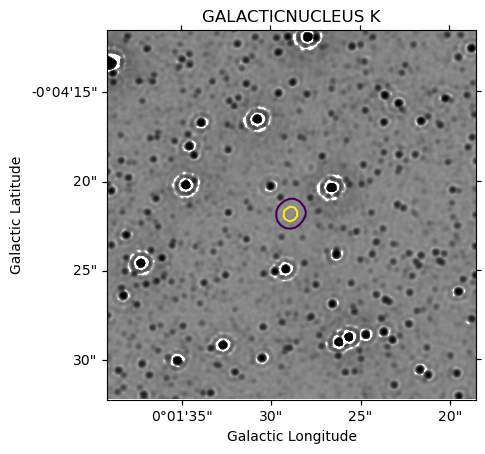

In [33]:
# Show continuum on NIR
fh = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/Field6_chip3holo_2_cal.fits')
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
#ax.set_xlabel("Right Ascension")
#ax.grid()
#ax.set_ylabel("Declination")
ax.set_ylabel("")
ax.set_xlabel("")
ax.coords['ra'].set_ticks_visible(False)
ax.coords['dec'].set_ticks_visible(False)
ax.coords['ra'].set_ticklabel_visible(False)
ax.coords['dec'].set_ticklabel_visible(False)
ax.set_title("GALACTICNUCLEUS K")

overlay = ax.get_coords_overlay('galactic')
#overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')
overlay[0].set_axislabel_position('b')
overlay[1].set_axislabel_position('l')
overlay[0].set_ticklabel_position('b')
overlay[1].set_ticklabel_position('l')

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/nir_continuum.pdf', bbox_inches='tight')

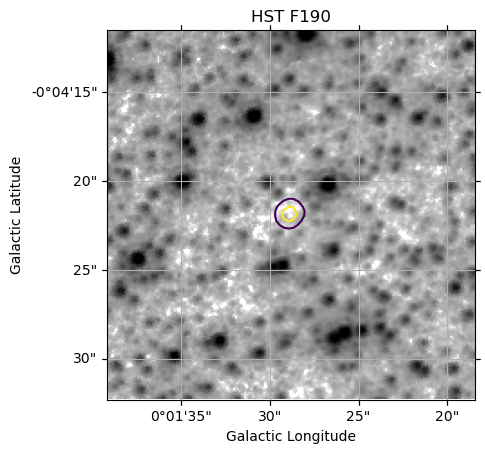

In [35]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST F190")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTF190nir_continuum.pdf', bbox_inches='tight')

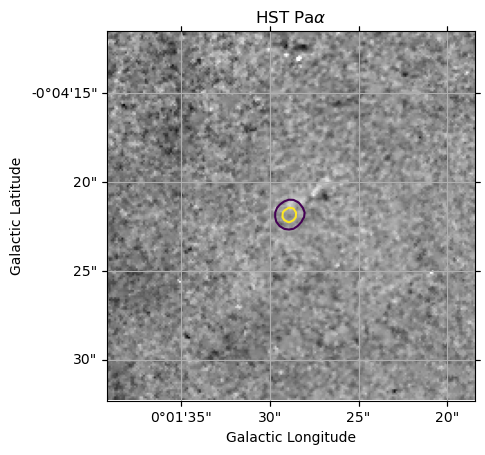

In [36]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_palpha_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='linear', min_cut=-0.5, max_cut=5),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST Pa$\\alpha$")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTPaAnir.pdf', bbox_inches='tight')

In [37]:
from astroquery.vizier import Vizier
virac = Vizier.query_region(coord, radius=15*u.arcsec, catalog='II/364/virac')[0]
hsc = Vizier.query_region(coord, radius=15*u.arcsec, catalog='II/342/hsc2')[0]
gns = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/A+A/631/A20/central')[0]
hst_dong = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/MNRAS/417/114/table2')[0]
pmq = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/A+A/662/A11/tablea1')[0]
pmq[:2]

RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,Hmag,e_Hmag,pml,e_pml,pmb,e_pmb
deg,arcsec,deg,arcsec,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.49124,0.00058,-28.95698,0.00092,14.78108,0.01764,1.32626,0.39429,-4.22008,0.27747
266.49188,0.00070,-28.95667,0.00106,16.27345,0.01727,4.23593,0.42302,-0.81900,0.28396


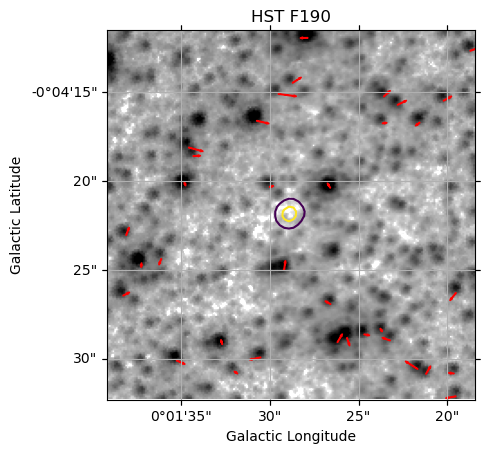

In [38]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST F190")
axlims = ax.axis()

crdpm = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg)).galactic
#ax.scatter_coord(crdpm, marker='.', s=15)
for row in pmq:
    crdpm = SkyCoord(row['RAJ2000'], row['DEJ2000'], frame='fk5', unit=(u.deg, u.deg)).galactic
    ax.arrow(crdpm.l.deg, crdpm.b.deg, row['pml']/36000, row['pmb']/36000,
             width=1e-5,
             color='r',
             transform=ax.get_transform('world'))

ax.axis(axlims)

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTF190nir_continuum_withPM.pdf', bbox_inches='tight')

In [ ]:
fhgns = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/Field6_chip3holo_2_cal.fits')
fhpaa = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_palpha_v1_img.fits')
fh190 = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
for fh in ([fhpaa, fh190]):
    fh[0].header['CTYPE1'] = 'GLON-TAN'
    fh[0].header['CTYPE2'] = 'GLAT-TAN'

fig = pl.figure()
for ii, fh in enumerate([fhgns, fhpaa, fh190]):
    
    nirim, nirwcs = galactic_cutout(fh, smallregion)
    
    ax = pl.subplot(3,1,1,projection=nirwcs)
    #ax = pl.subplot(projection=contwcs_co)
    im = ax.imshow(nirim.data, cmap='gray_r', norm=simple_norm(nirim, stretch='linear', max_percent=99.5, min_percent=1)
                   #transform=ax.get_transform(nirwcs[slcs]),
                  )
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               levels=[0.0008,  0.0015, ]);
    ax.set_xlabel("Galactic Longitude")
    #ax.grid()
    ax.set_ylabel("Galactic Latitude")
    #ax.set_title("HST Pa$\\alpha$")